!["question"](question.jpg)



between layer 1 and 2:

$$
\begin{bmatrix}
  b_{10} & w_{11} & w_{21} \\
  b_{20} & w_{12} & w_{22} 
\end{bmatrix}
$$

where b = bias and w = weights

$x = [0.1,0.2]$

In [10]:
import numpy as np
from sklearn.datasets import load_iris


input is columns, output is rows 

In [11]:
def Linear(num_nodes_input_layer, num_nodes_output_layer):
    """Dimensions: output is rows, input is columns."""
    weights = np.random.rand(num_nodes_output_layer, num_nodes_input_layer + 1) * 0.01
    # biases = np.ones((weights.shape[0], 1))

    # Stack the original array and the column of ones
    # return np.column_stack((biases, weights ))
    return weights


# Forward propogation to make predictions

!["how to apply the weights"](apply_weights.png)

$$ output = 
\begin{bmatrix}
  Neuron\:1\:applied\:to\:sample\:1 & Neuron\:2\:applied\:to\:sample\:1 \\
  Neuron\:1\:applied\:to\:sample\:2 & Neuron\:2\:applied\:to\:sample\:2
\end{bmatrix}
$$

In [ ]:
def compute_forward(inputs, layer):
    ## linear combination w0x0 + w1x1 + w2x2
    linear_combinations = []
    inputs = np.c_[ np.ones(inputs.shape[0]), inputs  ]    ## add bias to the inputs

    linear_combinations = np.matmul(inputs, layer.T) ## logits or z
    
    # print(linear_combinations)

    sigmoids = 1/(  1 + np.exp( -linear_combinations ) ) ## compute a
    # print(sigmoids)

    return linear_combinations, sigmoids



# Loss function

*m is number of samples*

*k is total number of output units*
$$
 J(θ)= - \frac{1}{m} {\sum^m_{i=1}\sum^k_{k=1} [y^{(i)}_kln(\frac{1}{1+e^{xθ^T}})_k + (1-y^{(i)}_k)ln(1-(\frac{1}{1+e^{xθ^T}})_k)]} 
$$
$$
 = \frac{1}{m} {\sum^m_{i=1}\sum^k_{k=1} [y^{(i)}_kln(a^{(L)}_k) + (1-y^{(i)}_k)ln(1-a^{(L)}_k)]}

$$


$$  
output\_sigmoids = 
\begin{bmatrix}
  Neuron\:1\:applied\:to\:sample\:1 & Neuron\:2\:applied\:to\:sample\:1 \\
  Neuron\:1\:applied\:to\:sample\:2 & Neuron\:2\:applied\:to\:sample\:2
\end{bmatrix}
$$

In [13]:
def binary_cross_entropy_loss(output_sigmoids, target):
    
    ## m is number of samples
    ## k is total number of output units

    target = target.reshape(-1,1)
    log_sigmoids = np.log(output_sigmoids)
    y_times_log_sigmoids = log_sigmoids * target ## element-wise multiplication

    one_minus_log_sigmoids = np.log(1 - output_sigmoids)
    one_minus_y_times_log_sigmoids = one_minus_log_sigmoids * (1 - target) ## element-wise multiplication
    # print(one_minus_y_times_log_sigmoids)
    
    return sum(sum((y_times_log_sigmoids + one_minus_y_times_log_sigmoids)))/len(target) * -1 ## sum across the output units and sum across the samples





In [ ]:
def compute_backpropogation(sigmoids: list, layers: list, y, x):
    """"""
    layers.reverse()

    sigmoids.insert(0, x)     
    sigmoids.reverse()
    gradients = []

    y = y.reshape(-1,1)
    # print(y)

    for i, layer in enumerate(layers):
        if i == 0:

            delta = (sigmoids[i] - y)
            # print(delta.shape)
            previous_sigmoids = np.c_[ np.ones(sigmoids[i+1].shape[0]), sigmoids[i+1]  ]    ## add bias to the inputs


            ## delta has shape (samples x nodes)
            ## sigmoids has shape (samples x activations + 1)
            ## ex delta = sx2 (s = samples & nodes = 2 )
            ##    sigmoids = sx3 (s = samples & there are 2 sigmoids and 1 to multiple the bias by)
            gradients.append(1/x.shape[0]*np.matmul(delta.T, previous_sigmoids))


        else:
            ## after the first delta, every previous delta is
            ## (delta * (weights from the previous layer)) * sigmoids or x
            delta = np.matmul(delta, layers[i-1][:,1:]) * sigmoids[i] * (1- sigmoids[i])
            previous_sigmoids = np.c_[ np.ones(sigmoids[i+1].shape[0]), sigmoids[i+1]  ]    ## add bias to the inputs
            # print(previous_sigmoids)
            gradients.append(1/x.shape[0]*np.matmul(delta.T, previous_sigmoids))


    # print(gradients)
    return gradients

def step(weights: list, gradients: list, lr = 0.01):
    # updated_weights = []
    gradients.reverse()
    for weight, gradient in zip(weights, gradients): ## so the first gradient is the input layers graidents
        yield weight - (gradient * lr)
        # weight = weight + (gradient * lr)
        # updated_weights.append(weight)

    # return updated_weights
    


In [15]:
iris = load_iris()

target = iris.target[(iris.target == 0) | (iris.target == 1)]
data = iris.data[(iris.target == 0) | (iris.target == 1)][:, :2]

indices = np.random.permutation(target.shape[0])
training_idx, test_idx = indices[:int(target.shape[0] * .7)], indices[int(target.shape[0] * .3):]
target_training, target_test = target[training_idx], target[test_idx]
data_training, data_test = data[training_idx], data[test_idx]




In [16]:
### put it all together:
EPOCHS = 5000

#### lists for plotting ####
loss_list = []


hidden_layer1 = Linear(2,2) ## weights and biases

output_layer = Linear(2,1) ## weights and biases

for epoch in range(EPOCHS):


    z2, sigmoids2 = compute_forward(data_training, hidden_layer1)

    z_output, output_sigmoids = compute_forward(sigmoids2, output_layer)

    loss = binary_cross_entropy_loss(output_sigmoids, target_training)
    loss_list.append(loss)

    gradients = compute_backpropogation(sigmoids = [sigmoids2, output_sigmoids], layers = [hidden_layer1, output_layer], y=target_training, x=data_training)
    hidden_layer1, output_layer = step(weights = [hidden_layer1, output_layer], gradients = gradients, lr = 0.1)

    if epoch % 100 == 0:
        print(f"----------------------epoch: {epoch}-----------------------")
        print(f"predictions:\n{(output_sigmoids.reshape(target_training.shape) > 0.5).astype(int)}\nActual:\n{target_training}")
        print(f"error: {loss}")
        print(f"correct prediction rate: {sum( (output_sigmoids.reshape(target_training.shape) > 0.5).astype(int) == target_training ) / len(target_training) * 100}%")

        


----------------------epoch: 0-----------------------
predictions:
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Actual:
[1 0 1 0 0 0 0 0 0 1 0 0 1 1 1 1 1 1 0 1 1 0 0 1 1 0 1 0 1 0 0 0 1 1 0 0 1
 1 0 0 1 1 0 0 0 0 0 0 0 0 1 0 0 1 1 1 0 1 1 0 1 1 1 1 1 1 0 0 1 1]
error: 0.6931654887110626
correct prediction rate: 50.0%
----------------------epoch: 100-----------------------
predictions:
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Actual:
[1 0 1 0 0 0 0 0 0 1 0 0 1 1 1 1 1 1 0 1 1 0 0 1 1 0 1 0 1 0 0 0 1 1 0 0 1
 1 0 0 1 1 0 0 0 0 0 0 0 0 1 0 0 1 1 1 0 1 1 0 1 1 1 1 1 1 0 0 1 1]
error: 0.693142351083335
correct prediction rate: 50.0%
----------------------epoch: 200-----------------------
predictions:
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 

### Make plots of loss


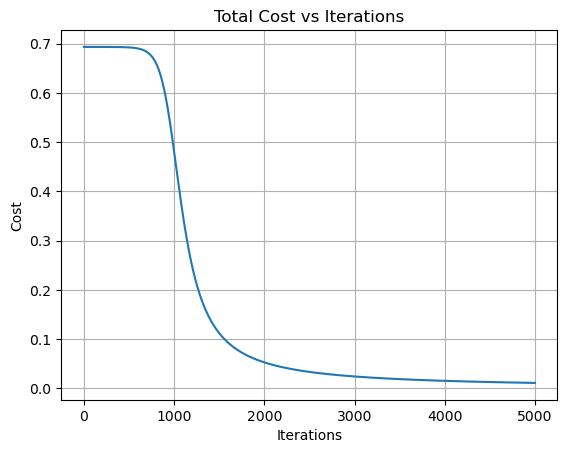

In [17]:
from matplotlib import pyplot as plt
## plot loss
plt.plot(loss_list)
plt.title("Total Cost vs Iterations")
plt.xlabel("Iterations")
plt.ylabel("Cost")
plt.grid()
plt.show()


#### test on unseen data

In [18]:
z2, sigmoids2 = compute_forward(data_test, hidden_layer1)
z_output, output_sigmoids = compute_forward(sigmoids2, output_layer)

loss = binary_cross_entropy_loss(output_sigmoids, target_test)

print(f"predictions:\n{(output_sigmoids.reshape(target_test.shape) > 0.5).astype(int)}\nActual:\n{target_test}")
print(f"error: {loss}")

print(f"correct predictions rate: {sum( (output_sigmoids.reshape(target_test.shape) > 0.5).astype(int) == target_test ) / len(target_test) * 100 }%")



predictions:
[0 0 1 1 0 0 1 1 0 0 1 1 0 0 0 0 0 0 0 0 1 0 0 1 1 1 0 1 1 0 1 1 1 1 1 1 0
 0 1 1 0 0 0 0 1 0 0 1 0 0 0 1 1 1 1 1 1 1 1 0 1 0 0 1 0 1 1 0 1 1]
Actual:
[0 0 1 1 0 0 1 1 0 0 1 1 0 0 0 0 0 0 0 0 1 0 0 1 1 1 0 1 1 0 1 1 1 1 1 1 0
 0 1 1 0 0 0 0 1 0 0 1 0 0 0 1 1 1 1 1 1 1 1 0 1 0 0 1 0 1 1 0 0 1]
error: 0.06462602493834302
correct predictions rate: 98.57142857142858%


# Sklearn

In [19]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

sk_model = MLPClassifier(hidden_layer_sizes=(2,), activation='logistic',
                         learning_rate_init=0.1, max_iter=5000, solver='sgd',random_state=1)

sk_model.fit(data_training, target_training)
sk_pred = sk_model.predict(data_test)
# sk_pred = sk_model.predict(data_training)

# loss = sk_model.loss_curve_

print("Sklearn MLP Accuracy:", accuracy_score(target_test, sk_pred))
# print("Sklearn MLP Accuracy:", accuracy_score(target_training, sk_pred))

Sklearn MLP Accuracy: 0.9857142857142858


# Torch

In [20]:
import torch
import torch.nn as nn
import torch.optim as optim

In [ ]:
class ANN(nn.Module):
    def __init__(self):
        super().__init__()


        # self.input = nn.Linear(2,2)
        self.hidden_layer1 = nn.Linear(2,2)
        self.output_layer = nn.Linear(2,1)

    def forward(self, x):
        # print(x)
        # x = self.input(x)
        # x = torch.sigmoid(x)
        x = self.hidden_layer1(x)
        x = torch.sigmoid(x)
        x = self.output_layer(x)

        return x
    
    def predict(self, x):
        x = self.forward(x)
        return (torch.sigmoid(x) > 0.5).to(torch.int16)
    
model = ANN()
x_vec = torch.tensor( data_training ).to(torch.float32)
tensor_target = torch.tensor(target_training).to(torch.float32)

optimizer = optim.SGD(model.parameters(), lr = 0.05)
criterion = nn.BCEWithLogitsLoss()

EPOCHS = 5000
for epoch in range(EPOCHS):
    optimizer.zero_grad() ## remove old gradients


    # ----- Forward Propagation -----
    output = model(x_vec)

    # ----- Compute Loss -----
    loss = criterion(output, tensor_target.reshape(-1,1))

    # ----- Backpropagation -----
    loss.backward()
    optimizer.step()

    output = torch.sigmoid(output)

    if (epoch + 1) % 1000 == 0:
        print(f"------------------------------epoch {epoch+1}--------------------------------------")
        print(f"                  loss: {loss}")
        print(f"predictions:\n{(output.reshape(tensor_target.shape) > 0.5).int()}\nActual:\n{tensor_target}")
        print(f"correct prediction rate: {sum( (output.reshape(tensor_target.shape) > 0.5).int() == tensor_target ) / len(tensor_target) * 100}%")
        # print(tensor_target)
        ## get amount of correct predictions

print(f"----------------predictions---------------------------")
predictions = model.predict(torch.tensor( data_test ).to(torch.float32))
loss = criterion(model(torch.tensor( data_test ).to(torch.float32)), torch.tensor( target_training ).to(torch.float32).reshape(-1,1))
print(f"\t\tloss: {loss}")
print(f"predictions:\n{predictions.reshape(target_training.shape)}")
print(f"Actual:\n{torch.tensor( target_training ).to(torch.float32)}")
print(f"correct prediction rate: {sum( predictions.reshape(target_training.shape) == torch.tensor( target_training ).to(torch.float32) ) / len(target_training) * 100}%")


------------------------------epoch 1000--------------------------------------
                  loss: 0.24123366177082062
predictions:
tensor([1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1,
        1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0,
        0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1],
       dtype=torch.int32)
Actual:
tensor([1., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 1., 1., 1., 1.,
        0., 1., 1., 0., 0., 1., 1., 0., 1., 0., 1., 0., 0., 0., 1., 1., 0., 0.,
        1., 1., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1.,
        1., 1., 0., 1., 1., 0., 1., 1., 1., 1., 1., 1., 0., 0., 1., 1.])
correct prediction rate: 100.0%
------------------------------epoch 2000--------------------------------------
                  loss: 0.07759696245193481
predictions:
tensor([1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1,
        1, 0, 1, 0, 1, 0, 0, 0, 1,

RuntimeError: mat1 and mat2 must have the same dtype, but got Double and Float